In [437]:
import pandas as pd
import torch
import numpy as np
from d2l import torch as d2l

In [481]:
# 读取数据
df = pd.read_csv('/home/zhaizhe/div-into-deeplearning/data/kaggle/HousePriceAdv/train.csv')
all_features = df.iloc[:, 1:-1]
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = torch.tensor(all_features.values, dtype=torch.float32)
all_labels = torch.tensor(df.SalePrice, dtype=torch.float32).reshape(1, -1)

In [516]:
def data_loader(batch_size):
    indices = np.arange(df.index.size)
    np.random.shuffle(indices)
    for i in range(0, df.index.size, batch_size):
        right = i + batch_size if i + batch_size < len(feature) else len(feature)
        features = all_features[indices[i:right]]
        label = all_labels[:,indices[i:right]]
        yield features, label
feature, label = next(data_loader(2))
print(feature.shape)

torch.Size([2, 331])


$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

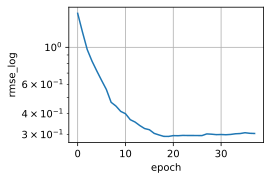

In [ ]:
# 定义模型
def linear_reg(W, X, b):
    return torch.matmul(X, W.reshape(-1, 1)) + b


def loss(y, y_hat):
    return (y - y_hat) ** 2 / 2;


# 定义损失函数，这里有一个重要错误（使用了均方损失），
# 对于房价我们更关心的是百分比差值而不是绝对值差值，因为房子的价格差异很大
def log_rmse(y, y_hat):
    cliped = torch.clamp(y_hat, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(y), torch.log(cliped)).mean())
    return rmse.item()

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def init_variables(input_shape):
    batch_size = 64
    lr = 0.05
    epochs = 100
    W = torch.normal(0, 0.054, size=(1, input_shape), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return epochs ,batch_size, lr, W, b

def train():
    epochs, batch_size, lr, W, b = init_variables(all_features.shape[1])
    animator = d2l.Animator(xlabel='epoch', ylabel='rmse_log', yscale='log')
    train_l = []
    for epoch in range(epochs):
        data_iter = data_loader(batch_size)
        for features, label in data_iter:
            y_hat = linear_reg(W, features, b)
            l = loss(label, y_hat)
            l.sum().backward()
            sgd([W, b], lr, batch_size)
        with torch.no_grad():
            y = linear_reg(W, all_features, b)
            l = log_rmse(all_labels, y)
            train_l.append(l)
            animator.add(epoch, [l])
    d2l.plot(list(range(len(train_l))), [train_l],
                xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                legend=['train'], yscale='log')
train()

# 总结
和教学课程中不一样的点：
- 数据需要清洗：规范化，补零
- 更关心预测值和真实值的百分比差异，所以用log_rmse表示

重要点
- 初始化模型参数很重要
- 学习步长
- 保证每个epoch数据顺序随机，不随机等于把上次结果重复运行 不会向目标靠近
- 数据获取，确保没有重复数据
- SGD优化param确保是指针传值，不是复制传值 不然param不会有变化